In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
from __future__ import print_function
import argparse
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [55]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3,32,3,1) #(32, 32, 3)
        self.conv2=nn.Conv2d(32,64,3,1) #(15, 15, 32)

        self.drop=nn.Dropout(0.5)
        self.fc1=nn.Linear(64*6*6,128)
        self.fc2=nn.Linear(128,10)

    def forward(self, x):        
        x=self.conv1(x)
        x=F.relu(x)
        x=F.max_pool2d(x,2,2)  #(30, 30, 32)  

        x=self.conv2(x)
        x=F.relu(x)
        x=F.max_pool2d(x,2,2) #(13, 13, 64)
        x=self.drop(x)

        x=x.view(-1,64*6*6)
        x=F.relu(x) 
        x=F.relu(x)
        x=self.fc1(x)  
        x=self.fc2(x)
        
        return F.log_softmax(x, dim=1)

dict_keys(['AIRPLANE', 'Apple Red 1', 'BIRD', 'DOG', 'FROG', 'Grape', 'HORSE', 'Kiwi', 'Lemon', 'Strawberry'])
32
dict_keys(['AIRPLANE', 'Apple Red 1', 'BIRD', 'DOG', 'FROG', 'Grape', 'HORSE', 'Kiwi', 'Lemon', 'Strawberry'])
32
Train Epoch: 0 [0/3637 (0%)]	Loss: 2.295113
Train Epoch: 0 [640/3637 (18%)]	Loss: 0.934058
Train Epoch: 0 [1280/3637 (35%)]	Loss: 1.124369
Train Epoch: 0 [1920/3637 (53%)]	Loss: 0.698069
Train Epoch: 0 [2560/3637 (70%)]	Loss: 0.716564
Train Epoch: 0 [3200/3637 (88%)]	Loss: 1.024596
Train Epoch: 1 [0/3637 (0%)]	Loss: 0.659905
Train Epoch: 1 [640/3637 (18%)]	Loss: 0.609488
Train Epoch: 1 [1280/3637 (35%)]	Loss: 0.608344
Train Epoch: 1 [1920/3637 (53%)]	Loss: 0.859519
Train Epoch: 1 [2560/3637 (70%)]	Loss: 0.994416
Train Epoch: 1 [3200/3637 (88%)]	Loss: 0.585428
Train Epoch: 2 [0/3637 (0%)]	Loss: 0.515684
Train Epoch: 2 [640/3637 (18%)]	Loss: 0.658284
Train Epoch: 2 [1280/3637 (35%)]	Loss: 0.488549
Train Epoch: 2 [1920/3637 (53%)]	Loss: 0.827229
Train Epoch: 2 [256

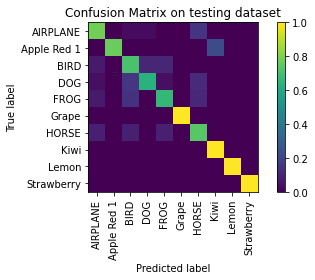

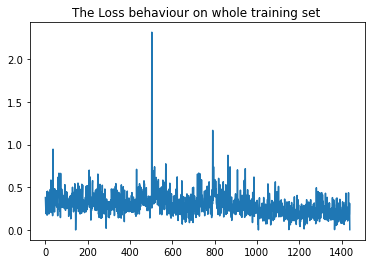

In [57]:
def main():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  testline = transforms.Compose([transforms.Resize([32, 32]), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  train = datasets.ImageFolder(root='/content/drive/Shared drives/Master Thesis and projects/DL-HW2/data/train', transform = testline)
  print(train.class_to_idx.keys())
  print(len(train[-1][0][0]))
  train_size = int(0.8 * len(train))
  valid_size = len(train) - train_size
  train_data, valid_data = torch.utils.data.random_split(train, [train_size, valid_size])
  full_train = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)

  test = datasets.ImageFolder(root='/content/drive/Shared drives/Master Thesis and projects/DL-HW2/data/test', transform = testline)
  print(test.class_to_idx.keys())
  print(len(test[-1][0][0]))
  test_loader = torch.utils.data.DataLoader(test,batch_size=64,shuffle=True)
  model = Net().to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.004)
  #optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)

  #print validation step
  for epoch in range(0, 20):  # loop over the dataset multiple times
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        #loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

  model.eval()
  valid_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in valid_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          valid_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

  valid_loss /= len(valid_loader.dataset)

  print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      valid_loss, correct, len(valid_loader.dataset),
      100. * correct / len(valid_loader.dataset)))
  

  #test step

  loss_values=[]
  predicted_label=[]
  true_label=[]
  start =time.time()

  for epoch in range(0, 20):  # loop over the dataset multiple times
    model.train()
    for batch_idx, (data, target) in enumerate(full_train):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        #loss = F.cross_entropy(output, target)
        loss_values.append(loss)
        loss.backward()
        optimizer.step()

  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
          predicted_label.extend(prediction.item() for prediction in pred )
          true_label.extend(label.item() for label in target)
  end=time.time()
  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

  print('\n Runtime of the training whole dataset and testing module is ', end-start, ' s')
  cn_matrix = confusion_matrix(
      y_true=true_label,
      y_pred=predicted_label,
      normalize="true")
  ConfusionMatrixDisplay(cn_matrix, list(test.class_to_idx.keys())).plot(
      include_values=False, xticks_rotation="vertical")
  plt.title("Confusion Matrix on testing dataset")
  plt.tight_layout()
  plt.show()

  plt.plot(loss_values)
  plt.title('The Loss behaviour on whole training set ')
  plt.show()
  torch.save(model.state_dict(),"hw2_cnn.pt")
        
if __name__ == '__main__':
  main()